In [0]:
#@title Install prerequsite

!pip install lifelines
!pip install shap

In [0]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from pathlib import Path

# Change this to where you download the files
DATA = Path("/content/drive/My Drive/Genomic Info/Genomics Project/tcga_hnsc")

In [0]:
import pandas as pd

full_train = pd.read_csv(DATA / "tcga_endpoints.txt", sep="\t")
hnsc_train = full_train[full_train.type == 'HNSC'] #528 patients
pfs_train = hnsc_train[['bcr_patient_barcode', 'PFI', 'PFI.time']].set_index('bcr_patient_barcode')
pfs_train.head()

PFI  PFI.time
bcr_patient_barcode               
TCGA-4P-AA8J         0.0     102.0
TCGA-BA-4074         1.0     396.0
TCGA-BA-4075         1.0     236.0
TCGA-BA-4076         1.0     286.0
TCGA-BA-4077         1.0    1134.0

As part of EDA, we can first construct the overall survival curve using the `lifelines` package.

### Clinical data

Regarding the features we will be using to predict survival, take a look at the clinical table:

In [0]:
clin_train = hnsc_train.set_index("bcr_patient_barcode")

clin_train.head()

type  ...  Redaction
bcr_patient_barcode        ...           
TCGA-4P-AA8J         HNSC  ...        NaN
TCGA-BA-4074         HNSC  ...        NaN
TCGA-BA-4075         HNSC  ...        NaN
TCGA-BA-4076         HNSC  ...        NaN
TCGA-BA-4077         HNSC  ...        NaN

[5 rows x 32 columns]

In [0]:
def cat_cont_summary_for_col(col: pd.Series, cat_cutoff: int):
    """Given a :class:`pandas.Series`, calculate its cardinality, and if its
    continuous, show summary statistics; if categorical, show unique values
    
    Arguments
    ---------
    col: pandas.Series
        Input series
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_info: dict
        A dictionary containing info regarding the input series. If the series
    """
    card = col.nunique()
    col_type = "cat" if card <= cat_cutoff else "cont"
    if col_type == "cont":
        col = pd.to_numeric(col, errors="coerce")
    else:
        col = col.astype(str)

    col_info = {
        "cardinality": card,
        "col_type": col_type,
        **col.describe()
    }
    if col_type == "cat":
        col_info["unique_values"] = col.unique()

    return col_info


def cat_cont_summary_for_df(df: pd.DataFrame, cat_cutoff: int = 20):
    """Given a :class:`pandas.DataFrame`, determine whether each column is
    categorical or continuous, and output its summary statistics
    
    Arguments
    ---------
    df: pandas.DataFrame
        Input data frame
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_summary: pandas.DataFrame
        A :class:`pandas.DataFrame` summarizing the statistics of each column
    """
    col_sums = [cat_cont_summary_for_col(df[col], cat_cutoff)
                for col in df.columns]
    col_summary = pd.DataFrame(col_sums)
    col_summary.index = df.columns.values
    return col_summary

In [0]:
import numpy as np

def replace_by_na(col: pd.Series, char: str = "["):
    idx = [char in str(x) for x in col]
    _col = col.copy()
    _col.loc[idx] = np.NaN
    return _col

# perform the same transformation to both clin_train and clin_test
for col in clin_train.columns:
    clin_train[col] = replace_by_na(clin_train[col])
    #clin_test[col] = replace_by_na(clin_test[col])


After this process, we can see the values in brackets are all converted to `np.NaN`

In [0]:
cat_cont_summary_for_df(clin_train)

cardinality col_type  ...      75%     max
type                                           1      cat  ...      NaN     NaN
age_at_initial_pathologic_diagnosis           60     cont  ...     69.0    90.0
gender                                         2      cat  ...      NaN     NaN
race                                           4      cat  ...      NaN     NaN
ajcc_pathologic_tumor_stage                    6      cat  ...      NaN     NaN
clinical_stage                                 6      cat  ...      NaN     NaN
histological_type                              3      cat  ...      NaN     NaN
histological_grade                             5      cat  ...      NaN     NaN
initial_pathologic_dx_year                    22     cont  ...   2011.0  2013.0
menopause_status                               0      cat  ...      NaN     NaN
birth_days_to                                519     cont  ... -19473.5 -7301.0
vital_status                                   2      cat  ...      NaN     NaN
tumor_status                                   2      cat  ...      NaN     NaN
last_contact_days_to                         296     cont  ...   1399.0  5480.0
death_days_to                                206     cont  ...    814.5  6417.0
cause_of_death                                 0      cat  ...      NaN     NaN
new_tumor_event_type                           4      cat  ...      NaN     NaN
new_tumor_event_site                           6      cat  ...      NaN     NaN
new_tumor_event_site_other                    76     cont  ...      NaN     NaN
new_tumor_event_dx_days_to                   134     cont  ...    499.0  3282.0
treatment_outcome_first_course                 5      cat  ...      NaN     NaN
margin_status                                  0      cat  ...      NaN     NaN
residual_tumor                                 0      cat  ...      NaN     NaN
OS                                             2      cat  ...      NaN     NaN
OS.time                                      465     cont  ...   1175.5  6417.0
DSS                                            2      cat  ...      NaN     NaN
DSS.time                                     465     cont  ...   1175.5  6417.0
DFI                                            2      cat  ...      NaN     NaN
DFI.time                                     132     cont  ...   1152.0  5480.0
PFI                                            2      cat  ...      NaN     NaN
PFI.time                                     460     cont  ...   1106.0  6417.0
Redaction                                      0      cat  ...      NaN     NaN

[32 rows x 14 columns]

The following code selected a few columns of interests (arbitrarily), convert the categorical variables to [one-hot encoding](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179), then these data frames are machine-learning ready.

In [0]:
cat_cols = ["ajcc_pathologic_tumor_stage", "histological_type", "histological_grade", "vital_status",
            "tumor_status", "new_tumor_event_type", "new_tumor_event_site"]
cont_cols = ["age_at_initial_pathologic_diagnosis", "death_days_to",
             "new_tumor_event_dx_days_to"]

In [0]:
# Concatenate categorical variables of interest and numerical variables of
# interest into ml-ready matrices
x_clin_train = pd.concat([pd.get_dummies(clin_train[cat_cols]),
                          clin_train[cont_cols]], axis=1, sort=True)

# x_clin_test = pd.concat([pd.get_dummies(clin_test[cat_cols]),
#                          clin_test[cont_cols]], axis=1, sort=True)

### RNASeq data

RNASeq data is very straight-forward. We have ~37,000 gene's expression values, all of them are log2 transformed, continuous values. 

In [0]:
ge_train = pd.read_csv(DATA / "hnsc_tcga_voom.txt", sep="\t", index_col=0)

#Manually drop repeated columns
ge_train = ge_train.drop(columns = ['TCGA-UF-A71A-06A','TCGA-KU-A6H7-06A'])

ge_train_names = []
drop_columns = []

for i in ge_train.columns:
  if i[13:14] == '0':   #Remove normal samples
    ge_train.rename(columns = {i:i[0:-4]}, inplace = True)
  else:
    drop_columns.append(i)
filter_ge = ge_train.drop(columns = drop_columns)
filter_ge.head()

TCGA-IQ-7632  TCGA-RS-A6TP  ...  TCGA-CV-6933  TCGA-D6-A6EN
TSPAN6          5.4638        4.0253  ...        5.6970        4.9408
TNMD           -6.3798       -7.2292  ...       -7.3445       -6.1539
DPM1            5.6121        5.1031  ...        5.1039        5.3183
SCYL3           3.1652        3.8281  ...        3.2527        2.5706
C1orf112        2.6728        3.4565  ...        3.0010        3.5096

[5 rows x 500 columns]

In [0]:
cidx_df = pd.read_csv(DATA/ "hnsc_cidx.txt",
                      sep=",")

In [0]:
# #Only run code if need to reconstruct cidx dataframe
mat = pd.concat([pfs_train, filter_ge.transpose()], axis=1, sort=True).dropna()

In [0]:
# from tqdm import tqdm
# from lifelines.utils import concordance_index

# out = []

# # calculate concordance index for all genes, THIS WILL TAKE A WHILE
# for i in tqdm(range(2, mat.shape[1]), total=mat.shape[1] - 2):
#     out.append((mat.columns[i],
#                 concordance_index(mat['PFI.time'],
#                                   mat.iloc[:, i],
#                                   mat.PFI)))

In [0]:
# cidx_df = pd.DataFrame(out)
# cidx_df.columns = ["gene", "cidx"]
# cidx_df["dev_from_random"] = (cidx_df.cidx - 0.5).abs()
# cidx_df.sort_values("dev_from_random", ascending=False, inplace=True)
# cidx_df = cidx_df.reset_index().set_index('index')

In [0]:
cidx_df.head()

index    gene      cidx  dev_from_random
0   5869    FGD3  0.612206         0.112206
1   5018   PCMT1  0.390095         0.109905
2   7978  SEC11A  0.391455         0.108545
3   6062  CCDC32  0.391559         0.108441
4   6709  TCEAL4  0.391897         0.108103

In [0]:
# cidx_df.to_csv(DATA/"cidx.txt")

In [0]:
# create gene sets out of top concordance index genes
top_genes_negative = cidx_df.iloc[:400].gene
top_genes_positive = cidx_df.iloc[-400:].gene
_ge = filter_ge.loc[pd.concat([top_genes_negative,
                              top_genes_positive], axis=0)].copy()

In [0]:
corr = (_ge.T).corr()

In [0]:
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import squareform

cor_dist = 1 - (corr + 1) / 2
linkage = hc.linkage(squareform(cor_dist), method="average")
labels = cor_dist.columns.values
coexp_set = pd.DataFrame({"cluster": hc.fcluster(linkage, 0.25,"distance"),
                          "gene": labels})

In [0]:
def create_coexp_ge_features(ge, coexp_set, min_gene_set=10):
    geneset_size = coexp_set.groupby("cluster").size()
    geneset_size = geneset_size[geneset_size >= min_gene_set]

    coexp_set_ = coexp_set.set_index("cluster", drop=True)

    tmp = {}
    for gs in geneset_size.index.values:
        genes = coexp_set_.loc[gs].gene.values
        if geneset_size[gs] <= 5:
            gsname = "_".join(list(genes))
        else:
            gsname = genes[0] + "_" + "geneset"
        
        tmp[gsname] = ge.loc[genes].mean(axis=0)
    
    return pd.DataFrame(tmp)

In [0]:
ge_train_feat = create_coexp_ge_features(filter_ge, coexp_set)
# ge_test_feat = create_coexp_ge_features(ge_test, coexp_set)

In [0]:
# gene sets from https://academiccommons.columbia.edu/doi/10.7916/D8NP22JK 
attractors = {
    "LYM": ["SASH3", "CD53", "NCKAP1L", "LCP2", "IL10RA", "PTPRC", "EVI2B",
            "BIN2", "WAS", "HAVCR2"],
    "CIN": ["TPX2", "KIF4A", "KIFC1", "NCAPG", "BUB1", "NCAPH", "CDCA5",
            "KIF2C", "PLK1", "CENPA"],
    "MES": ["COL3A1", "COL5A2", "COL1A2", "THBS2", "COL5A1", "VCAN", "COL6A3",
            "SPARC", "AEBP1", "FBN1"],
    "END": ["CDH5", "ROBO4", "CXorf36", "CD34", "CLEC14A", "ARHGEF15", "CD93",
            "LDB2", "ELTD1", "MYCT1"]
}

def create_metagenes(ge, genesets):
    tmp = {}
    for gs in genesets:
        genes = [x for x in genesets[gs] if x in ge.index]
        tmp[gs] = ge.loc[genes].mean(axis=0)
    return pd.DataFrame(tmp)

In [0]:
ge_train_feat = pd.concat(
    [ge_train_feat, create_metagenes(filter_ge, attractors)], axis=1
)

# ge_test_feat = pd.concat(
#     [ge_test_feat, create_metagenes(ge_test, attractors)], axis=1
# )

We'll just use these top genes to feed to our models. If you want to further improve, you can also try to **combine co-expressed genes into gene set** to reduce co-linearity.

In [0]:
x_ge_train = ge_train_feat.copy()
# x_ge_test = ge_test_feat.copy()

### Mutation data

Finally let's take a look at mutation data. The mutation data has the same format of MAF files. Here we'll aggregate the `MODERATE` and `HIGH` impact mutations by genes and pivot it into a matrix.

In [0]:
maf_file = DATA / "TCGA.HNSC.mutect.1aa33f25-3893-4f37-a6a4-361c9785d07e.DR-10.0.somatic.maf.gz"

mut_train = pd.read_csv(maf_file, sep="\t", comment='#')

mut_train['bcr_patient_barcode'] = mut_train.Tumor_Sample_Barcode.str[0:12]

mut_train.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (87,118) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Hugo_Symbol  Entrez_Gene_Id  ... GDC_Validation_Status bcr_patient_barcode
0        RPA2            6118  ...               Unknown        TCGA-T2-A6X0
1      SLC6A9            6536  ...               Unknown        TCGA-T2-A6X0
2       PTCH2            8643  ...               Unknown        TCGA-T2-A6X0
3       PDE4B            5142  ...               Unknown        TCGA-T2-A6X0
4       SPTA1            6708  ...               Unknown        TCGA-T2-A6X0

[5 rows x 121 columns]

In [0]:
mut_pts_train = set(mut_train.bcr_patient_barcode)
# mut_pts_test = set(mut_test.patient_id)

In [0]:
x_mut_train = mut_train[
    (mut_train.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_train.FILTER == "PASS")
].pivot_table(index="bcr_patient_barcode", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_train[x_mut_train > 0] = 1
x_mut_train.fillna(0, inplace=True)

# x_mut_test = mut_test[
#     (mut_test.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_test.FILTER == "PASS")
# ].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# # convert the values to 1 if there is a mutation, else fill in 0
# x_mut_test[x_mut_test > 0] = 1
# x_mut_test.fillna(0, inplace=True)

In [0]:
mut_freq = x_mut_train.sum(axis=0).sort_values(ascending=False)
top_mut_genes = mut_freq.index.values[2:100]

In [0]:
# only include a few known mutated genes
x_mut_train = x_mut_train[list(top_mut_genes) + ["EGFR", "KRAS", "BRAF", "ROS1"]]
# x_mut_test = x_mut_test[list(top_mut_genes) + ["EGFR", "KRAS", "BRAF", "ROS1"]]

# to prevent duplicated gene names from mutation matrix and ge matrix, we add
# suffix of `_mut` to all the genes in mut table

x_mut_train.columns = [x + "_mut" for x in x_mut_train.columns]
# x_mut_test.columns = [x + "_mut" for x in x_mut_test.columns]

### Combine different modalities

After pre-processing, we now can finally put clinical, RNASeq and mutation information all together, and create a training and testing matrices for our machine learning models.

In [0]:
x_train = pd.concat([x_clin_train, x_ge_train, x_mut_train], axis=1, sort=True)
# x_test = pd.concat([x_clin_test, x_ge_test, x_mut_test], axis=1, sort=True)

In [0]:
x_train.shape

(528, 141)

In [0]:
# simple median value impute
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
x_train_imp = pd.DataFrame(imp_mean.fit_transform(x_train),
                           index=x_train.index, columns=x_train.columns)
# x_test_imp = pd.DataFrame(imp_mean.fit_transform(x_test),
#                           index=x_test.index, columns=x_test.columns)

In [0]:
# Use only common columns of the training and test set
# common_columns = set(x_train_imp.columns) & set(x_test_imp.columns)
# x_train_imp = x_train_imp[list(common_columns)]
# x_test_imp = x_test_imp[list(common_columns)]

In [0]:
x_train_imp.head()

ajcc_pathologic_tumor_stage_Stage I  ...  ROS1_mut
TCGA-4P-AA8J                                  0.0  ...       0.0
TCGA-BA-4074                                  0.0  ...       0.0
TCGA-BA-4075                                  0.0  ...       0.0
TCGA-BA-4076                                  0.0  ...       0.0
TCGA-BA-4077                                  0.0  ...       0.0

[5 rows x 141 columns]

In [0]:
import xgboost as xgb

In [0]:
# convert the censored time in PFS to negative
# Since XGBoost only allow one column for y, the censoring information
# is coded as negative values:

y_train = (np.where(pfs_train.PFI == 1, 1, -1) *
           pfs_train['PFI.time'])
dtrain = xgb.DMatrix(x_train_imp, label=y_train.values)

In [0]:
xgb_params = {
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
}

In [0]:
good_pts = y_train.index.values[y_train.notnull()]
y_train = y_train.loc[good_pts]
x_train_imp = x_train_imp.loc[good_pts]
dtrain = xgb.DMatrix(x_train_imp, label=y_train.values)

In [0]:
cvout = xgb.cv(xgb_params, dtrain, num_boost_round=1000, nfold=10,
               early_stopping_rounds=10, seed=0)

In [0]:
# get the best (minimum) loss score
cv_rounds = cvout["test-cox-nloglik-mean"].idxmin()

In [0]:
# THIS STEP CREATES THE MODEL; RUN SHAP HERE
xgbmodel = xgb.train(xgb_params, 
                     dtrain, num_boost_round=cv_rounds)

In [0]:
import shap

explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(x_train_imp)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], x_train_imp.iloc[[0]])

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_train_imp)

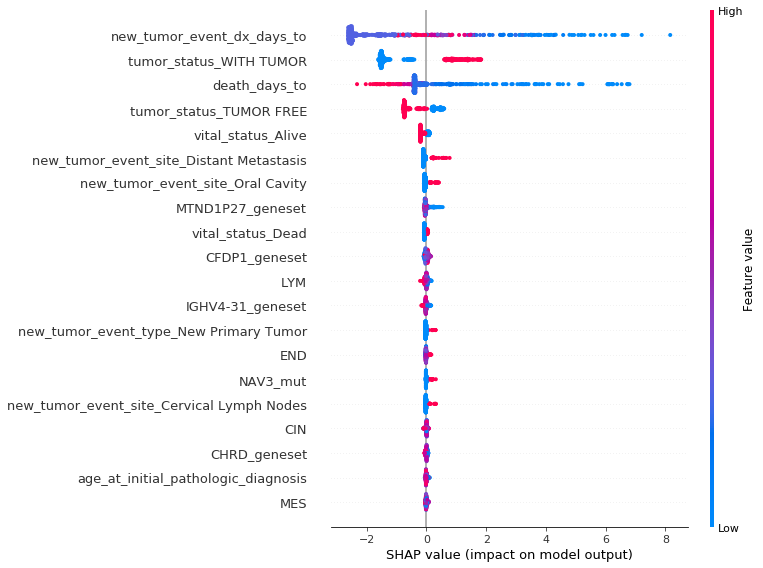

In [0]:
shap.summary_plot(shap_values, x_train_imp)

In [0]:
# # First construct a data frame with all the variables needed
pfs_train = pfs_train.loc[good_pts]

mat = pd.concat([pfs_train.copy(), x_train_imp[["LYM"]]],
              axis=1, sort=True)

mat["LYM"] = mat["LYM"] >= 0.6
mat.rename(columns={"LYM": "HIGH_LYM"}, inplace=True)
mat.head()

#CIN': P = 0.11
#ZNF804B_mut': P = 0.80
#MES': P = 0.64
#LYM': P = 0.002668*********; Optimized to P = 0.000004 at expression of 0.6
#END': P = 0.097
#WITH TUMOR: P = 2.096060e-58
#Age at initial diagnosis: P = 0.24179
#MTND_geneset: P = 0.142
#IGHV4-31_geneset: P = 0.000011*********; Optimized to P = 0.000297 at 0.42

PFI  PFI.time  HIGH_LYM
bcr_patient_barcode                         
TCGA-4P-AA8J         0.0     102.0      True
TCGA-BA-4074         1.0     396.0      True
TCGA-BA-4075         1.0     236.0      True
TCGA-BA-4076         1.0     286.0      True
TCGA-BA-4077         1.0    1134.0      True

In [0]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(mat, duration_col='PFI.time',
        event_col='PFI')

<lifelines.CoxPHFitter: fitted with 527 total observations, 329 right-censored observations>

In [0]:
cph.summary

coef  exp(coef)  se(coef)  ...         z         p   -log2(p)
HIGH_LYM -1.786503   0.167545  0.389481  ... -4.586878  0.000004  17.761887

[1 rows x 10 columns]

In [0]:
print("The concordance index between PFI Time and LYM  is {:.4f}".format(
    1 - cph.score_
))

The concordance index between PFI Time and LYM  is 0.4830


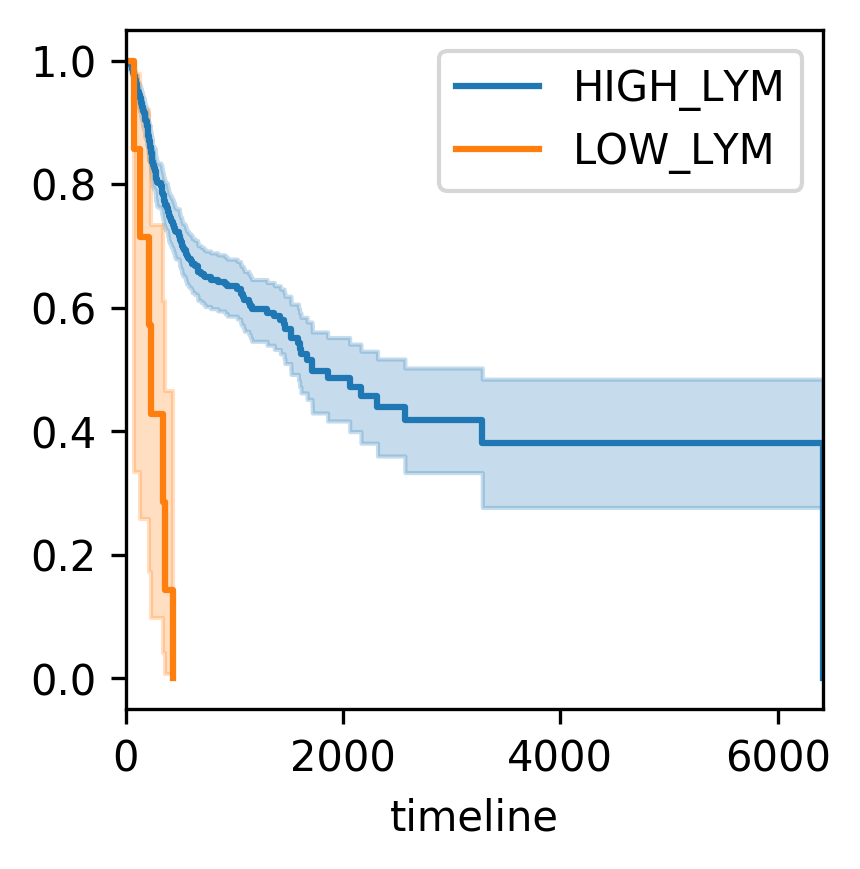

In [0]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(pfs_train['PFI.time'], pfs_train.PFI)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(dpi=300, figsize=(3, 3))

luad_idx = mat.HIGH_LYM
kmf.fit(mat['PFI.time'][luad_idx], mat.PFI[luad_idx], label="HIGH_LYM")
kmf.plot(ax=ax)
kmf.fit(mat['PFI.time'][~luad_idx],mat.PFI[~luad_idx],label="LOW_LYM")
kmf.plot(ax=ax)

In [0]:
pfs_train = pfs_train.loc[good_pts]

mat = pd.concat([pfs_train.copy(), x_train_imp[["IGHV4-31_geneset"]]],
              axis=1, sort=True)

mat["IGHV4-31_geneset"] = mat["IGHV4-31_geneset"] >= 0.42
mat.rename(columns={"IGHV4-31_geneset": "HIGH_IGHV4_31_geneset"}, inplace=True)
mat.head()

PFI  PFI.time  HIGH_IGHV4_31_geneset
bcr_patient_barcode                                      
TCGA-4P-AA8J         0.0     102.0                   True
TCGA-BA-4074         1.0     396.0                  False
TCGA-BA-4075         1.0     236.0                  False
TCGA-BA-4076         1.0     286.0                  False
TCGA-BA-4077         1.0    1134.0                   True

In [0]:
cph = CoxPHFitter()
cph.fit(mat, duration_col='PFI.time',
        event_col='PFI')

<lifelines.CoxPHFitter: fitted with 527 total observations, 329 right-censored observations>

In [0]:
cph.summary

coef  exp(coef)  ...         p   -log2(p)
HIGH_IGHV4_31_geneset -0.523121   0.592668  ...  0.000297  11.718604

[1 rows x 10 columns]

In [0]:
print("The concordance index between PFI Time and High IGHV4-31_geneset  is {:.4f}".format(
    1 - cph.score_
))

The concordance index between PFI Time and LYM  is 0.4208


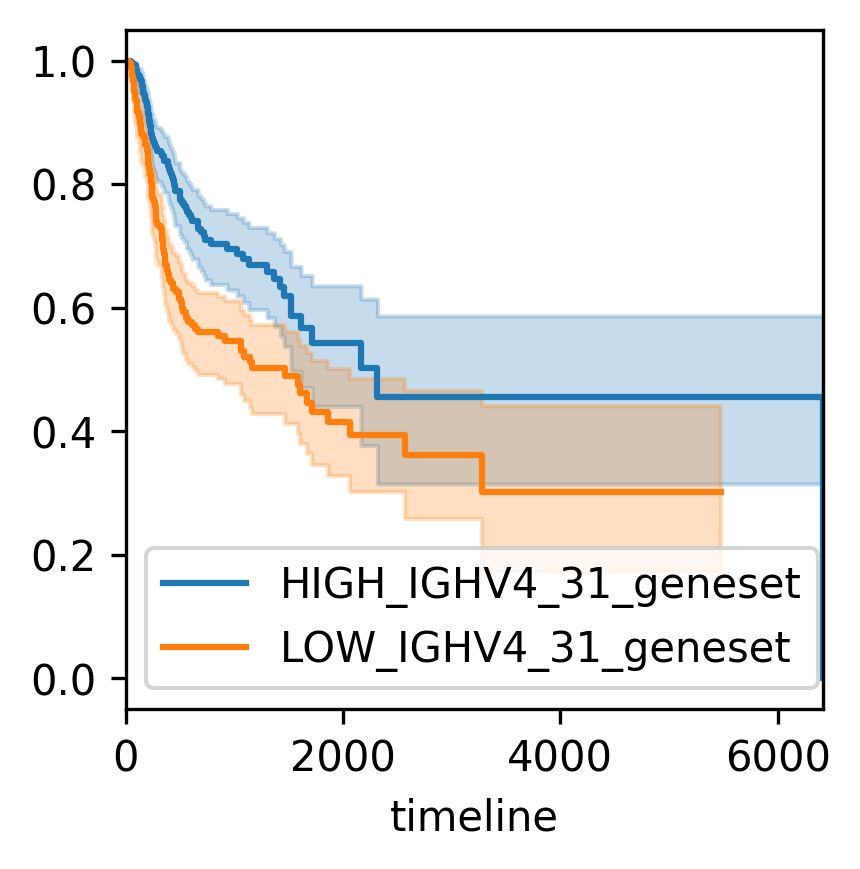

In [0]:
kmf = KaplanMeierFitter()
kmf.fit(pfs_train['PFI.time'], pfs_train.PFI)

fig, ax = plt.subplots(dpi=300, figsize=(3, 3))

luad_idx = mat.HIGH_IGHV4_31_geneset
kmf.fit(mat['PFI.time'][luad_idx], mat.PFI[luad_idx], label="HIGH_IGHV4_31_geneset")
kmf.plot(ax=ax)
kmf.fit(mat['PFI.time'][~luad_idx],mat.PFI[~luad_idx],label="LOW_IGHV4_31_geneset")
kmf.plot(ax=ax)